## Phase 1: Environment Setup & Data Ingestion


**Tujuan:** Untuk memuat semua dataset mentah dari berbagai file `.json`, melakukan pembersihan data, **mengekstrak fitur interaksi (reply)**, menyeragamkan strukturnya, dan menggabungkannya menjadi satu **DataFrame master** yang siap untuk tahap analisis berikutnya.

**Langkah-langkah yang akan dilakukan:**
1.  **Install Requirements:** Memasang semua library yang diperlukan.
2.  **Import Libraries:** Memuat semua *library* yang diperlukan.
3.  **Define JSON Preprocessing Function:** Membuat fungsi serbaguna untuk membersihkan setiap file JSON.
4.  **Execute & Merge:** Menjalankan fungsi pada semua file JSON dan menggabungkan hasilnya.
5.  **Visualize & Save:** Membuat visualisasi dari data yang sudah digabung dan menyimpannya ke file baru.


### 1.1. Dependency Importation

In [1]:
import pandas as pd
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

warnings.filterwarnings('ignore')

### 1.2. Define The Universal JSON Preprocessing Function

**Logika di dalam fungsi ini:**
1.  **Membaca JSON:** Memuat data dari path file JSON yang diberikan.
2.  **Menyeragamkan Kolom:** Mengganti nama kolom dari format JSON (`tweetId`, `userName`, `content`) menjadi format standar (`id`, `username`, `text`).
3.  **Menambahkan Kolom Topic:** Membuat kolom `topic` berdasarkan nama file sumber untuk memudahkan analisis.
4.  **Ekstraksi Fitur `reply_to_user`:** Menggunakan *Regular Expression* (regex) untuk mendeteksi jika sebuah tweet diawali dengan `@username`, dan mengekstrak nama pengguna tersebut.
5.  **Membersihkan Data:** Melakukan serangkaian operasi pembersihan yang sama seperti sebelumnya.


In [2]:
def preprocess_json_data(file_path):
    print(f"\nProcessing file: {file_path}...")
    try:
        df = pd.read_json(file_path)
    except FileNotFoundError:
        print(f"  -> ⚠️ File not found. Skipping.")
        return None
    except Exception as e:
        print(f"  -> ❌ Error loading file: {e}. Skipping.")
        return None

    rename_map = {
        'tweetId': 'id',
        'userName': 'username',
        'content': 'text',
        'createdAt': 'timestamp'
    }
    df.rename(columns=rename_map, inplace=True)
    
    required_columns = ['id', 'text', 'timestamp', 'username']
    if not all(col in df.columns for col in required_columns):
        print(f"  -> ❌ Critical columns missing after renaming. Skipping.")
        return None
        
    topic = file_path.split('/')[-1].replace('.json', '').replace('Tuntuan', 'Tuntutan')
    df['topic'] = topic
    
    def extract_reply_to(text):
        if not isinstance(text, str): return None
        match = re.match(r'^@(\w+)', text)
        return match.group(1) if match else None
    df['reply_to_user'] = df['text'].apply(extract_reply_to)
    
    initial_rows = len(df)
    
    df.dropna(subset=['text', 'username'], inplace=True)
    df.drop_duplicates(subset=['id'], keep='first', inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', format='mixed')
    df.dropna(subset=['timestamp'], inplace=True)

    def clean_text(text):
        if not isinstance(text, str): return ""
        text = text.lower()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'[^a-z\s]', '', text)
        text = " ".join(text.split())
        return text.strip()
    df['cleaned_text'] = df['text'].apply(clean_text)
    
    final_columns = ['id', 'text', 'timestamp', 'username', 'reply_to_user', 'cleaned_text', 'topic']
    df = df[final_columns]
    
    print(f"  -> ✅ Processing complete. Shape: {df.shape} (from {initial_rows} initial rows)")
    return df

print("\n--- 1.3. Preprocessing Function for JSON Defined ---")
print("Function 'preprocess_json_data' is ready to use.")


--- 1.3. Preprocessing Function for JSON Defined ---
Function 'preprocess_json_data' is ready to use.


### 1.3. Process and Merge All Datasets

Hasil dari setiap file yang bersih akan digabungkan menjadi satu **DataFrame master**.

In [3]:
json_files = [
    'n8n/DPR.json',
    'n8n/MosiTidakPercaya.json',
    'n8n/Pertamina.json',
    'n8n/RKUHP.json',
    'n8n/Tuntutan17+8.json'
]

all_dfs = [preprocess_json_data(file) for file in json_files]
all_dfs = [df for df in all_dfs if df is not None]


Processing file: n8n/DPR.json...
  -> ✅ Processing complete. Shape: (490, 7) (from 490 initial rows)

Processing file: n8n/MosiTidakPercaya.json...
  -> ✅ Processing complete. Shape: (67, 7) (from 312 initial rows)

Processing file: n8n/Pertamina.json...
  -> ✅ Processing complete. Shape: (833, 7) (from 833 initial rows)

Processing file: n8n/RKUHP.json...
  -> ✅ Processing complete. Shape: (156, 7) (from 449 initial rows)

Processing file: n8n/Tuntutan17+8.json...
  -> ✅ Processing complete. Shape: (419, 7) (from 510 initial rows)


In [4]:
if all_dfs:
    master_df = pd.concat(all_dfs, ignore_index=True)
    
    print("\n--- Merging DataFrames ---")
    print(f"Shape before final duplicate check: {master_df.shape}")
    
    master_df.drop_duplicates(subset=['id'], keep='first', inplace=True)
    
    print("\n--- ✅ PHASE 1 COMPLETED ---")
    print(f"All JSON files have been processed and merged successfully.")
    print(f"Final Master DataFrame Shape: {master_df.shape}")
    
    pd.set_option('display.max_rows', 100) 
    
    print("\n--- Full Output of Master Data ---")
    print(master_df)
    
    print("\n--- Data Info ---")
    master_df.info()

else:
    print("\n--- ❌ PHASE 1 FAILED ---")
    print("No data was processed. Please check your file paths and formats.")




--- Merging DataFrames ---
Shape before final duplicate check: (1965, 7)

--- ✅ PHASE 1 COMPLETED ---
All JSON files have been processed and merged successfully.
Final Master DataFrame Shape: (1960, 7)

--- Full Output of Master Data ---
                       id                                               text  \
0     1968910080759214336  @txtdrimedia Langkahnya terhenti di DPR, tapi ...   
1     1967111501300593152  DPR Nepal resmi dibubarkan\nMau dibersihkan da...   
2     1971033026273677824  Petani (Rakyat) ingin menyampaikan aspirasi ba...   
3     1969754118618284032  Anggota Komisi III DPR Sarifuddin Sudding meng...   
4     1968217799840633344  Hari ini Humanies Project turut mengawal drive...   
...                   ...                                                ...   
1960  1971506148428960256  Kasus MBG,kasus orang-orang yang hilang sejak ...   
1961  1971392752018747904  @PalPriadi @kerasnyalyfe Bukan kk. Itu dia up ...   
1962  1971361044359721216  @kompascom Men

### 1.5. Visualisasi Distribusi Data

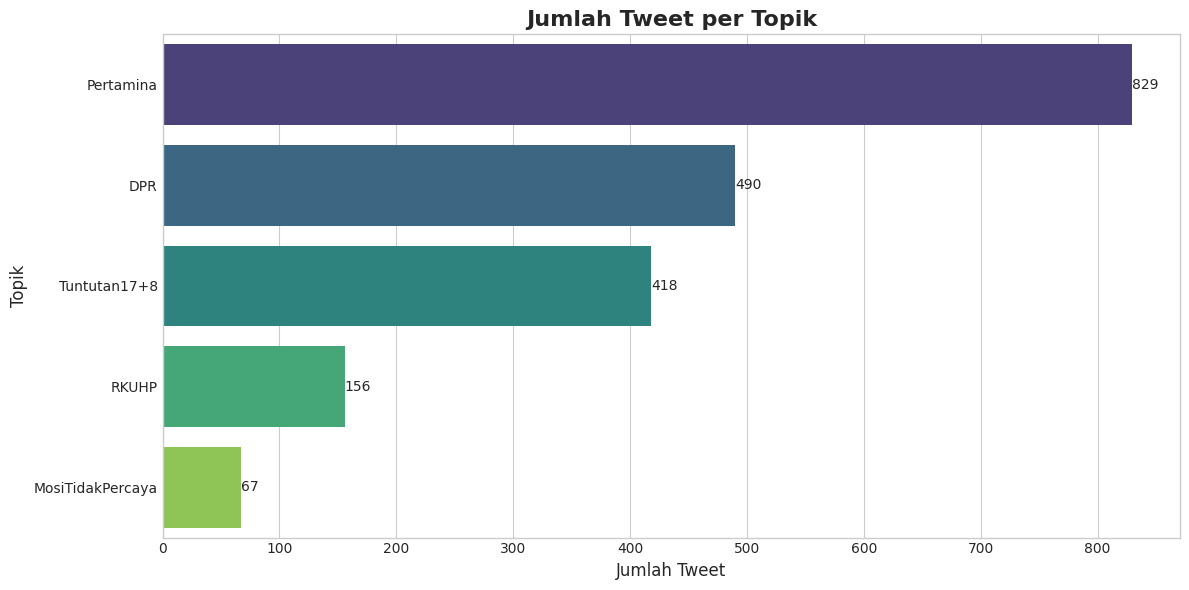

In [5]:
if 'master_df' in locals() and not master_df.empty:
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 6))
    
    ax = sns.countplot(y=master_df['topic'], order=master_df['topic'].value_counts().index, palette='viridis')
    
    ax.set_title('Jumlah Tweet per Topik', fontsize=16, fontweight='bold')
    ax.set_xlabel('Jumlah Tweet', fontsize=12)
    ax.set_ylabel('Topik', fontsize=12)
    
    for container in ax.containers:
        ax.bar_label(container, fontsize=10)
    
    plt.tight_layout()
    plt.show()

### 1.6. Menyimpan DataFrame Master ke File CSV

In [6]:
if 'master_df' in locals() and not master_df.empty:
    output_filename = 'master_dataset_cleaned.csv'
    master_df.to_csv(output_filename, index=False)
    print(f"✅ DataFrame master berhasil disimpan ke file: '{output_filename}'")

✅ DataFrame master berhasil disimpan ke file: 'master_dataset_cleaned.csv'


In [7]:
if 'master_df' in locals() and not master_df.empty:
    print("\n--- ✅ PHASE 1 COMPLETED ---")
    print(f"Final Master DataFrame Shape: {master_df.shape}")
    
    # Mengatur opsi Pandas untuk menampilkan lebih banyak baris
    pd.set_option('display.max_rows', 100)
    
    print("\n--- Pratinjau Master Data (Tabel Interaktif) ---")
    display(master_df)
    
    print("\n--- Info Detail DataFrame ---")
    master_df.info()



--- ✅ PHASE 1 COMPLETED ---
Final Master DataFrame Shape: (1960, 7)

--- Pratinjau Master Data (Tabel Interaktif) ---


,id,text,timestamp,username,reply_to_user,cleaned_text,topic
0,1968910080759214336,"@txtdrimedia Langkahnya terhenti di DPR, tapi ...",2025-09-19 05:28:00,JAditya36003,txtdrimedia,langkahnya terhenti di dpr tapi jejaknya di ru...,DPR
1,1967111501300593152,DPR Nepal resmi dibubarkan\nMau dibersihkan da...,2025-09-14 06:21:00,CakKhum,None,dpr nepal resmi dibubarkan mau dibersihkan dar...,DPR
2,1971033026273677824,Petani (Rakyat) ingin menyampaikan aspirasi ba...,2025-09-25 02:04:00,King_SpeakUp,None,petani rakyat ingin menyampaikan aspirasi baik...,DPR
3,1969754118618284032,Anggota Komisi III DPR Sarifuddin Sudding meng...,2025-09-21 13:22:00,kegblgnunfaedh,None,anggota komisi iii dpr sarifuddin sudding meng...,DPR
4,1968217799840633344,Hari ini Humanies Project turut mengawal drive...,2025-09-17 07:37:00,humaniesproject,None,hari ini humanies project turut mengawal drive...,DPR
...,...,...,...,...,...,...,...
1960,1971506148428960256,"Kasus MBG,kasus orang-orang yang hilang sejak ...",2025-09-26 09:24:00,inid97,None,kasus mbgkasus orangorang yang hilang sejak de...,Tuntutan17+8
1961,1971392752018747904,@PalPriadi @kerasnyalyfe Bukan kk. Itu dia up ...,2025-09-26 01:53:00,snwoocrush,PalPriadi,bukan kk itu dia up igs gitu pas demo kemarin ...,Tuntutan17+8
1962,1971361044359721216,@kompascom Menyerang balik setelah ditindas ak...,2025-09-25 23:47:00,yesmar_banu,kompascom,menyerang balik setelah ditindas akibat pajak ...,Tuntutan17+8
1963,1971264610503172352,wargi !upi punten adakah yang tau lanjutan tun...,2025-09-25 17:24:00,uppifess,None,wargi upi punten adakah yang tau lanjutan tunt...,Tuntutan17+8



--- Info Detail DataFrame ---
<class 'pandas.core.frame.DataFrame'>
Index: 1960 entries, 0 to 1964
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             1960 non-null   object        
 1   text           1960 non-null   object        
 2   timestamp      1960 non-null   datetime64[ns]
 3   username       1960 non-null   object        
 4   reply_to_user  773 non-null    object        
 5   cleaned_text   1960 non-null   object        
 6   topic          1960 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 122.5+ KB
